In [39]:
# This notebook uses Kernel Density Estimation to analyze, plot, and compare the
# distributions of day-over-day returns for various MAANG stocks.

In [40]:
import pandas as pd
import numpy as np

#import data
df = pd.read_csv('/workspaces/DensityEstimation/data/maamg_prices.csv')

In [41]:
# The MAAMG prices dataset contains the opening-, closing-, intra-day low- / high- prices, and trading volume
# in distinct columns across all the MAAMG stock tickers.
df.head()

,MSFT_Date,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,AMZN_Date,AMZN_Open,AMZN_High,...,GOOG_Close,GOOG_Adj Close,GOOG_Volume,AAPL_Date,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
0,11/9/21,337.109985,338.720001,334.529999,335.950012,333.159790,21307400,11/9/21,175.762497,179.688507,...,149.248505,149.248505,16876000,11/9/21,150.199997,151.429993,150.059998,150.809998,149.939758,56787900
1,11/10/21,334.570007,334.630005,329.920013,330.799988,328.052551,25500900,11/10/21,178.193497,180.272507,...,146.626007,146.626007,22708000,11/10/21,150.020004,150.130005,147.850006,147.919998,147.066467,65187100
2,11/11/21,331.250000,333.769989,330.510010,332.429993,329.669006,16849800,11/11/21,175.649994,177.162003,...,146.748001,146.748001,12464000,11/11/21,148.960007,149.429993,147.679993,147.869995,147.016739,41000000
3,11/12/21,333.920013,337.230011,333.790009,336.720001,333.923370,23831000,11/12/21,174.250000,177.036499,...,149.645493,149.645493,17048000,11/12/21,148.429993,150.399994,147.479996,149.990005,149.124527,63804000
4,11/15/21,337.540009,337.880005,334.029999,336.070007,333.278778,16723000,11/15/21,176.850006,179.694000,...,149.388000,149.388000,16248000,11/15/21,150.369995,151.880005,149.429993,150.000000,149.134460,59222800


In [42]:
# We will use 235 days worth of data.
df.shape

(253, 35)

In [43]:
# We will explore Google and Meta for now, but this can be replicated across any of the tickers.
# We can look at the day-ove-day price changes on a log scale to see how these two models perform.
# We use the closing prices for simplicity.
goog_log_returns = np.log((df['GOOG_Close'].iloc[1:].values/df['GOOG_Close'].iloc[:-1].values).reshape(-1,1))
meta_log_returns = np.log((df['META_Close'].iloc[1:].values/df['META_Close'].iloc[:-1].values).reshape(-1,1))

In [44]:
goog_log_returns[:5]

array([[-0.01772756],
       [ 0.00083166],
       [ 0.01955228],
       [-0.00172217],
       [-0.00209068]])

In [57]:
# We split the data into training and test sets and use Kernel Density Estimation (KDE)
# to fit the distribution of log-returns data.
from sklearn.model_selection import train_test_split

goog_train, goog_test = train_test_split(goog_log_returns, test_size = .2, random_state=0)
meta_train, meta_test = train_test_split(meta_log_returns, test_size = .2, random_state=0)

In [58]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

def KernelDensityEstimator(log_returns_data, kernel, k_fold, bandwidth_search_range):
    """
    Returns a fitted Kernel Density Estimator (KDE) for the given day-over-day
    log returns data using grid search with `k-fold` cross-validation to
    determine the optimal bandwith for the KDE estimate.
    
    The KDE estimator looks an awful lot like a Fourier transform. Indeed it can be
    shown that the KDE estimator is equivalent to the Fourier transform of the characteristic function estimator
    (i.e. point estimation of E[e^(itX)]) convoluted with some dampening function psi in C^1.
    The kernel K corresponds to the Fourier transform of psi. The dampening function allows the Fourier transform
    to converge. See https://en.wikipedia.org/wiki/Kernel_density_estimation for details.

    Note that cross-validation simplifies bandwidth selection. Other approaches are used in the statistics community
    based on loss functions like MISE (mean integrated squared error). See https://en.wikipedia.org/wiki/Kernel_density_estimation#Bandwidth_selection
    and https://www.stat.cmu.edu/~larry/=sml/densityestimation.pdf for more on the alternative approaches and
    https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/#Bandwidth-selection for a comparison of
    the GridSearchCV + KernelDensity implementation vs. alternatives like SciPy's gaussian_kde class and Statsmodel's KDEUnivariate.

    Args:
    - log_returns_data. A numpy ndarray of the log returns data.
    - kernel. The kernel used for the KDE estimate.
    - k_fold. The integer k to use for k-fold cross-validation.
    - bandwidth_search_range. The range to be used for grid search.

    """
    grid = GridSearchCV(KernelDensity(kernel=kernel), param_grid={'bandwidth' : bandwidth_search_range}, cv = k_fold)
    return grid.fit(log_returns_data.reshape(-1,1))

In [59]:
bandwidth_search_range = np.linspace(0.001,.1,1000)
k_fold = 10
goog_kde = KernelDensityEstimator(goog_train, 'gaussian', k_fold, bandwidth_search_range)
meta_kde = KernelDensityEstimator(meta_train, 'gaussian', k_fold, bandwidth_search_range)

In [76]:
# The optimal bandwidths for Google and Meta:
goog_kde.best_estimator_, meta_kde.best_estimator_

(KernelDensity(bandwidth=0.012396396396396399),
 KernelDensity(bandwidth=0.021315315315315317))

In [74]:
# The range of log-returns we want to plot.
log_returns_range = np.linspace(-.2, .2, 10000).reshape(-1,1)

def GetDensities(kde_estimator, data):
    """
    Returns the likelihood, i.e. density, of each input in the given `data`
    under the given `kde_estimator`.
    """
    log_densities = kde_estimator.score_samples(data)
    densities = np.exp(log_densities)
    return densities 

goog_densities = GetDensities(goog_kde, log_returns_range)
meta_densities = GetDensities(meta_kde, log_returns_range)

In [75]:
import scipy.stats

def SummaryStatistics(data):
    """
    Returns a NumPy darray of some summary statistics for the given data.
    Specifically, it returns the length, minimum, maximum, mean, median, mode, stddev, skew, and kurtosis.

    
    Args:
    - data: A Pandas dataframe.
    """

    sumstats = np.array([len(data), np.min(data), np.max(data), np.mean(data), np.median(data), float(scipy.stats.mode(data)[0]), np.std(data), float(scipy.stats.skew(data)[0]), float(scipy.stats.kurtosis(data)[0])])
    return sumstats

summary_statistics = pd.DataFrame(index = ["N", "MIN", "MAX", "MEAN", "MEDIAN", "MODE", "STD DEV", "SKEW", "KURT"], data = {"GOOG": SummaryStatistics(goog_train), "META": SummaryStatistics(meta_train)})

/tmp/ipykernel_32171/1588474880.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  sumstats = np.array([len(data), np.min(data), np.max(data), np.mean(data), np.median(data), float(scipy.stats.mode(data)[0]), np.std(data), float(scipy.stats.skew(data)[0]), float(scipy.stats.kurtosis(data)[0])])


In [62]:
summary_statistics

,GOOG,META
N,201.000000,201.000000
MIN,-0.101313,-0.306391
MAX,0.074541,0.162064
MEAN,-0.001680,-0.004391
MEDIAN,-0.000745,-0.002245
MODE,-0.101313,-0.306391
STD DEV,0.023949,0.042833
SKEW,-0.156063,-2.788780
KURT,1.409300,19.906502


In [63]:
import matplotlib.pyplot as plt
def PlotKernelDensityEstimates(ticker, input_range, densities):
    """
    Plots the given densities 
    """
    plt.plot(log_returns_range, densities, color = 'black')
    plt.title('%s daily log returns between 11/10/21 - 11/09/22' % ticker)
    plt.xlabel("Log return")
    plt.ylabel("Density")
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


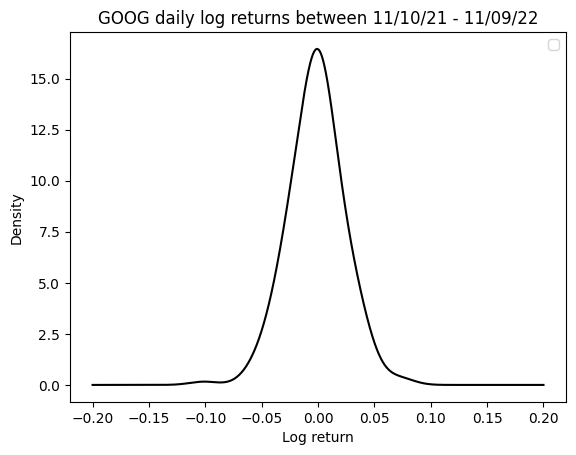

In [64]:
log_returns_range = np.linspace(-.2, .2, 10000).reshape(-1,1)
PlotKernelDensityEstimates("GOOG", log_returns_range, goog_densities)

In [65]:
# Indeed the log returns data is quite normal and the KDE estimates
# reflect many of the properties shown in the summary statistics.
# For example, Meta has higher volatility and kurtosis.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


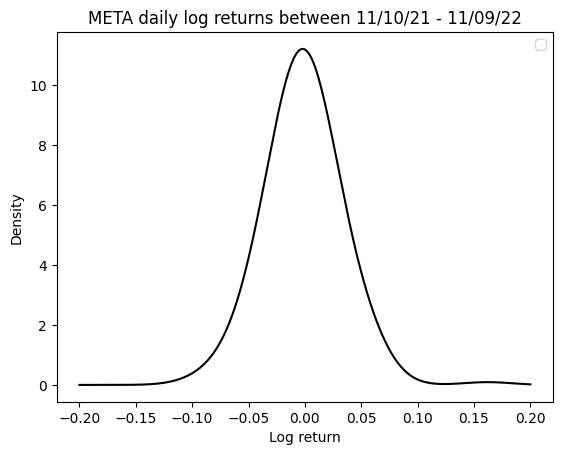

In [66]:
PlotKernelDensityEstimates("META", log_returns_range, meta_densities)

Text(0, 0.5, 'Density')

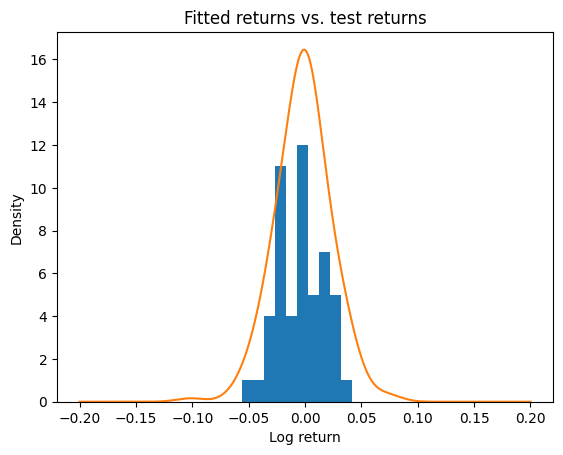

In [77]:
# We should compare the KDE plots with the actual test data.
flattened_goog_test = goog_test.flatten()
plt.hist(flattened_goog_test, bins=10)
plt.plot(log_returns_range, goog_densities)
plt.title('Fitted returns vs. test returns')
plt.xlabel("Log return")
plt.ylabel("Density")

In [78]:
# The estimate performs reasonably well, although the fitted mean is
# slightly right of the test mean.